In [3]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('data/24(거래금액,등락율,전세가율,건축년도,전용면적,관리시설수,주택금융여부).xlsx')
df

,Unnamed: 0,ID,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,거래금액(만원)_18/2,주택금융가능여부.1,...,건축년도.16,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,관리시설수,위도,경도
0,0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,0,4.162633,32.7,80,1987.0,145000.0,0,...,1987.0,218666.7,0,1.7,27.1,80,1987.0,NaN,37.483372,127.053437
1,1,서울특별시 강남구 개포동 개포주공1단지 40,145736.8,0,16.507998,7.0,40,1982.0,162587.5,0,...,1982.0,180000.0,0,0.0,5.6,40,1982.0,NaN,37.483381,127.057068
2,2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,0,0.000000,31.2,60,1983.0,129500.0,0,...,1983.0,202800.0,0,0.0,21.8,60,1983.0,5.0,37.487868,127.068988
3,3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,0,0.000000,25.4,80,1983.0,177416.7,0,...,1983.0,282250.0,0,0.0,22.1,80,1983.0,5.0,37.487868,127.068988
4,4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,0,9.134234,30.1,50,1983.0,128000.0,0,...,1983.0,189000.0,0,0.0,22.8,50,1983.0,3.0,37.488481,127.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,4294,서울특별시 중랑구 중화동 중화동건영아파트 60,25000.0,1,6.000000,10.0,60,1998.0,27000.0,1,...,1998.0,47500.0,1,0.0,50.8,60,1998.0,NaN,37.605430,127.082936
4087,4295,서울특별시 중랑구 중화동 태능에셈빌 80,35000.0,1,0.000000,42.9,80,2005.0,36875.0,1,...,2005.0,71000.0,0,0.0,21.1,80,2005.0,NaN,37.599447,127.078938
4088,4296,서울특별시 중랑구 중화동 한신아파트 50,31756.2,1,0.000000,77.4,50,1997.0,32190.0,1,...,1997.0,70000.0,0,0.0,52.9,50,1997.0,5.0,37.595961,127.080314
4089,4297,서울특별시 중랑구 중화동 한신아파트 60,36534.6,1,2.996064,76.9,60,1997.1,38387.5,1,...,1997.1,73000.0,0,0.0,49.5,60,1997.1,5.0,37.595961,127.080314


In [5]:
del df['Unnamed: 0']

In [6]:
df.dropna(inplace=True)

In [7]:
df.head()

,ID,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,거래금액(만원)_18/2,주택금융가능여부.1,등락율.16,...,건축년도.16,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,관리시설수,위도,경도
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,0,0.000000,31.2,60,1983.0,129500.0,0,-5.5,...,1983.0,202800.0,0,0.0,21.8,60,1983.0,5.0,37.487868,127.068988
3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,0,0.000000,25.4,80,1983.0,177416.7,0,0.0,...,1983.0,282250.0,0,0.0,22.1,80,1983.0,5.0,37.487868,127.068988
4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,0,9.134234,30.1,50,1983.0,128000.0,0,1.6,...,1983.0,189000.0,0,0.0,22.8,50,1983.0,3.0,37.488481,127.072502
5,서울특별시 강남구 개포동 개포주공6단지 60,135200.0,0,9.023669,31.8,60,1983.0,131650.0,0,-2.7,...,1983.0,181000.0,0,0.0,21.7,60,1983.0,3.0,37.488481,127.072502
6,서울특별시 강남구 개포동 개포주공6단지 70,151500.0,0,10.451045,33.2,70,1983.0,150500.0,0,-0.7,...,1983.0,270000.0,0,0.0,21.2,70,1983.0,3.0,37.488481,127.072502


In [8]:
where = df.iloc[:,110:112]
where

,위도,경도
2,37.487868,127.068988
3,37.487868,127.068988
4,37.488481,127.072502
5,37.488481,127.072502
6,37.488481,127.072502
...,...,...
4083,37.604124,127.082326
4084,37.594222,127.075432
4088,37.595961,127.080314
4089,37.595961,127.080314


In [9]:
gongtong = df.iloc[:,109]
gongtong

2       5.0
3       5.0
4       3.0
5       3.0
6       3.0
       ... 
4083    4.0
4084    4.0
4088    5.0
4089    5.0
4090    5.0
Name: 관리시설수, Length: 3295, dtype: float64

In [10]:
df.iloc[:,1:7]

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도
2,136666.7,0,0.000000,31.2,60,1983.0
3,177416.7,0,0.000000,25.4,80,1983.0
4,125900.0,0,9.134234,30.1,50,1983.0
5,135200.0,0,9.023669,31.8,60,1983.0
6,151500.0,0,10.451045,33.2,70,1983.0
...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,1991.0
4084,44000.0,1,0.000000,85.2,80,2010.0
4088,31756.2,1,0.000000,77.4,50,1997.0
4089,36534.6,1,2.996064,76.9,60,1997.1


In [11]:
dic = {}
num = 1

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num:num+6]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],gongtong], axis=1)
    num += 6

dic['data1']

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,관리시설수
2,136666.7,0,0.000000,31.2,60,1983.0,5.0
3,177416.7,0,0.000000,25.4,80,1983.0,5.0
4,125900.0,0,9.134234,30.1,50,1983.0,3.0
5,135200.0,0,9.023669,31.8,60,1983.0,3.0
6,151500.0,0,10.451045,33.2,70,1983.0,3.0
...,...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,1991.0,4.0
4084,44000.0,1,0.000000,85.2,80,2010.0,4.0
4088,31756.2,1,0.000000,77.4,50,1997.0,5.0
4089,36534.6,1,2.996064,76.9,60,1997.1,5.0


In [12]:
dic['data18']

,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,관리시설수
2,202800.0,0,0.0,21.8,60,1983.0,5.0
3,282250.0,0,0.0,22.1,80,1983.0,5.0
4,189000.0,0,0.0,22.8,50,1983.0,3.0
5,181000.0,0,0.0,21.7,60,1983.0,3.0
6,270000.0,0,0.0,21.2,70,1983.0,3.0
...,...,...,...,...,...,...,...
4083,56933.3,1,0.0,83.4,80,1991.0,4.0
4084,78800.0,0,0.0,44.4,80,2010.0,4.0
4088,70000.0,0,0.0,52.9,50,1997.0,5.0
4089,73000.0,0,0.0,49.5,60,1997.1,5.0


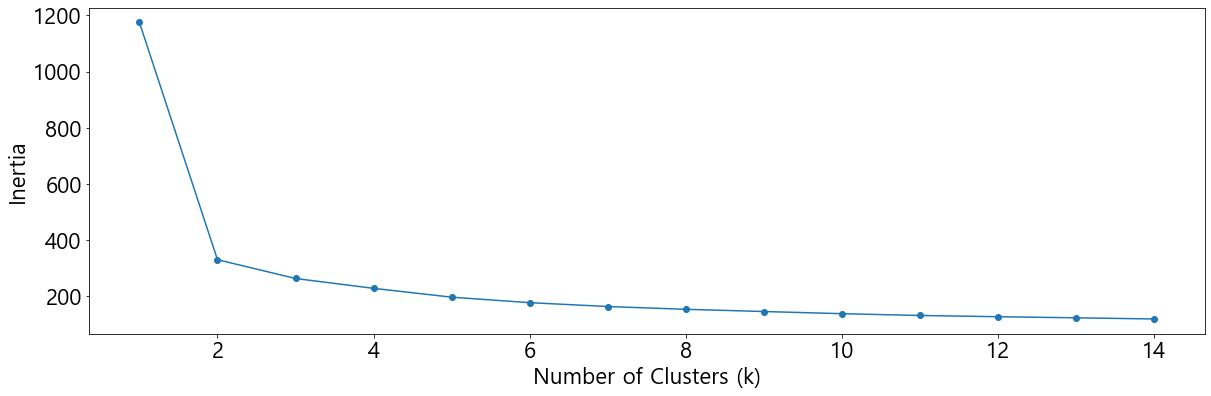

In [13]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

num_clusters = list(range(1, 15))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [14]:
# 스케일링과 클러스터링
mm = StandardScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [15]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,관리시설수
cluster,,,,,,,
0,1906,1906,1906,1906,1906,1906,1906
1,1389,1389,1389,1389,1389,1389,1389


In [16]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,주택금융가능여부.8,등락율.9,전세가율.9,전용면적.8,건축년도.8,관리시설수
cluster,,,,,,,
0,1470,1470,1470,1470,1470,1470,1470
1,1825,1825,1825,1825,1825,1825,1825


In [17]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,관리시설수
cluster,,,,,,,
0,1857,1857,1857,1857,1857,1857,1857
1,1438,1438,1438,1438,1438,1438,1438


In [18]:
# 스케일링과 클러스터링
mm = MinMaxScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [19]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,관리시설수
cluster,,,,,,,
0,611,611,611,611,611,611,611
1,1206,1206,1206,1206,1206,1206,1206
2,464,464,464,464,464,464,464
3,699,699,699,699,699,699,699
4,315,315,315,315,315,315,315


In [20]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,주택금융가능여부.8,등락율.9,전세가율.9,전용면적.8,건축년도.8,관리시설수
cluster,,,,,,,
0,844,844,844,844,844,844,844
1,965,965,965,965,965,965,965
2,641,641,641,641,641,641,641
3,325,325,325,325,325,325,325
4,520,520,520,520,520,520,520


In [21]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,관리시설수
cluster,,,,,,,
0,805,805,805,805,805,805,805
1,437,437,437,437,437,437,437
2,706,706,706,706,706,706,706
3,95,95,95,95,95,95,95
4,1252,1252,1252,1252,1252,1252,1252


In [22]:
data1 = dic['data1'].groupby(['cluster','주택금융가능여부']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','주택금융가능여부.1']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','주택금융가능여부.2']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','주택금융가능여부.3']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','주택금융가능여부.4']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','주택금융가능여부.5']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','주택금융가능여부.6']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','주택금융가능여부.7']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','주택금융가능여부.8']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','주택금융가능여부.9']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','주택금융가능여부.10']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','주택금융가능여부.11']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','주택금융가능여부.12']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','주택금융가능여부.13']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','주택금융가능여부.14']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','주택금융가능여부.15']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','주택금융가능여부.16']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','주택금융가능여부.17']).count().iloc[:,1:2]

In [23]:
data1

등락율18/1
cluster 주택금융가능여부         
0       0             608
        1               3
1       0              10
        1            1196
2       0             463
        1               1
3       0               3
        1             696
4       0             313
        1               2

In [24]:
data18

등락율
cluster 주택금융가능여부.17      
0       0             805
1       0             147
        1             290
2       0             706
3       0              44
        1              51
4       0            1252

In [25]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

등락율18/1  등락율.16  등락율.15  등락율.14  등락율.13  등락율.12  등락율.11  등락율.10  \
cluster                                                                      
0       0      608   658.0     758   691.0   709.0   718.0   742.0   802.0   
        1        3     NaN       1     NaN     NaN     NaN     NaN     NaN   
1       0       10    18.0      49    68.0    34.0    79.0    95.0    93.0   
        1     1196  1143.0    1040  1061.0  1074.0  1038.0   988.0   921.0   
2       0      463   496.0     549   583.0   584.0   567.0   591.0   622.0   
        1        1     3.0       1     1.0     NaN     NaN     NaN     1.0   
3       0        3     3.0      11     5.0     3.0    13.0    16.0    22.0   
        1      696   642.0     538   442.0   438.0   466.0   414.0   341.0   
4       0      313   328.0     346   444.0   451.0   413.0   449.0   493.0   
        1        2     4.0       2     NaN     2.0     1.0     NaN     NaN   

           등락율.9  등락율.8  등락율.7  등락율.6  등락율.5  등락율.4  등락율.3  등락율.2   등락율.1  \
cluster                                                                     
0       0  844.0  872.0  895.0  928.0  760.0  964.0  954.0  841.0   764.0   
        1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
1       0  138.0  257.0   76.0  228.0  367.0  245.0  232.0  334.0   357.0   
        1  827.0  735.0  649.0  538.0  464.0  394.0  308.0  289.0   291.0   
2       0  641.0  640.0  687.0  682.0  677.0  689.0  698.0  682.0   676.0   
        1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
3       0   40.0   79.0   25.0   97.0  146.0   93.0   81.0  142.0   150.0   
        1  285.0  241.0  152.0  122.0   96.0   73.0   51.0   48.0    51.0   
4       0  520.0  471.0  811.0  700.0  785.0  837.0  971.0  959.0  1006.0   
        1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   

              등락율  
cluster            
0       0   805.0  
        1     NaN  
1       0   147.0  
        1   290.0  
2       0   706.0  
        1     NaN  
3       0    44.0  
        1    51.0  
4       0  1252.0  
        1     NaN

In [26]:
total = total.transpose()
total

cluster      0           1              2           3              4     
             0    1      0       1      0    1      0      1       0    1
등락율18/1  608.0  3.0   10.0  1196.0  463.0  1.0    3.0  696.0   313.0  2.0
등락율.16   658.0  NaN   18.0  1143.0  496.0  3.0    3.0  642.0   328.0  4.0
등락율.15   758.0  1.0   49.0  1040.0  549.0  1.0   11.0  538.0   346.0  2.0
등락율.14   691.0  NaN   68.0  1061.0  583.0  1.0    5.0  442.0   444.0  NaN
등락율.13   709.0  NaN   34.0  1074.0  584.0  NaN    3.0  438.0   451.0  2.0
등락율.12   718.0  NaN   79.0  1038.0  567.0  NaN   13.0  466.0   413.0  1.0
등락율.11   742.0  NaN   95.0   988.0  591.0  NaN   16.0  414.0   449.0  NaN
등락율.10   802.0  NaN   93.0   921.0  622.0  1.0   22.0  341.0   493.0  NaN
등락율.9    844.0  NaN  138.0   827.0  641.0  NaN   40.0  285.0   520.0  NaN
등락율.8    872.0  NaN  257.0   735.0  640.0  NaN   79.0  241.0   471.0  NaN
등락율.7    895.0  NaN   76.0   649.0  687.0  NaN   25.0  152.0   811.0  NaN
등락율.6    928.0  NaN  228.0   538.0  682.0  NaN   97.0  122.0   700.0  NaN
등락율.5    760.0  NaN  367.0   464.0  677.0  NaN  146.0   96.0   785.0  NaN
등락율.4    964.0  NaN  245.0   394.0  689.0  NaN   93.0   73.0   837.0  NaN
등락율.3    954.0  NaN  232.0   308.0  698.0  NaN   81.0   51.0   971.0  NaN
등락율.2    841.0  NaN  334.0   289.0  682.0  NaN  142.0   48.0   959.0  NaN
등락율.1    764.0  NaN  357.0   291.0  676.0  NaN  150.0   51.0  1006.0  NaN
등락율      805.0  NaN  147.0   290.0  706.0  NaN   44.0   51.0  1252.0  NaN

In [27]:
total.div(total.sum(axis=1), axis=0)

cluster         0                   1                   2                   3  \
                0         1         0         1         0         1         0   
등락율18/1  0.184522  0.000910  0.003035  0.362974  0.140516  0.000303  0.000910   
등락율.16   0.199697       NaN  0.005463  0.346889  0.150531  0.000910  0.000910   
등락율.15   0.230046  0.000303  0.014871  0.315630  0.166616  0.000303  0.003338   
등락율.14   0.209712       NaN  0.020637  0.322003  0.176935  0.000303  0.001517   
등락율.13   0.215175       NaN  0.010319  0.325948  0.177238       NaN  0.000910   
등락율.12   0.217906       NaN  0.023976  0.315023  0.172079       NaN  0.003945   
등락율.11   0.225190       NaN  0.028832  0.299848  0.179363       NaN  0.004856   
등락율.10   0.243399       NaN  0.028225  0.279514  0.188771  0.000303  0.006677   
등락율.9    0.256146       NaN  0.041882  0.250986  0.194537       NaN  0.012140   
등락율.8    0.264643       NaN  0.077997  0.223065  0.194234       NaN  0.023976   
등락율.7    0.271624       NaN  0.023065  0.196965  0.208498       NaN  0.007587   
등락율.6    0.281639       NaN  0.069196  0.163278  0.206980       NaN  0.029439   
등락율.5    0.230653       NaN  0.111381  0.140819  0.205463       NaN  0.044310   
등락율.4    0.292564       NaN  0.074355  0.119575  0.209105       NaN  0.028225   
등락율.3    0.289530       NaN  0.070410  0.093475  0.211836       NaN  0.024583   
등락율.2    0.255235       NaN  0.101366  0.087709  0.206980       NaN  0.043096   
등락율.1    0.231866       NaN  0.108346  0.088316  0.205159       NaN  0.045524   
등락율      0.244310       NaN  0.044613  0.088012  0.214264       NaN  0.013354   

cluster                   4            
                1         0         1  
등락율18/1  0.211229  0.094992  0.000607  
등락율.16   0.194841  0.099545  0.001214  
등락율.15   0.163278  0.105008  0.000607  
등락율.14   0.134143  0.134750       NaN  
등락율.13   0.132929  0.136874  0.000607  
등락율.12   0.141426  0.125341  0.000303  
등락율.11   0.125645  0.136267       NaN  
등락율.10   0.103490  0.149621       NaN  
등락율.9    0.086495  0.157815       NaN  
등락율.8    0.073141  0.142944       NaN  
등락율.7    0.046131  0.246131       NaN  
등락율.6    0.037026  0.212443       NaN  
등락율.5    0.029135  0.238240       NaN  
등락율.4    0.022155  0.254021       NaN  
등락율.3    0.015478  0.294689       NaN  
등락율.2    0.014568  0.291047       NaN  
등락율.1    0.015478  0.305311       NaN  
등락율      0.015478  0.379970       NaN